In [2]:
%pylab inline 
import cv2
from IPython.display import clear_output

Populating the interactive namespace from numpy and matplotlib


We will use the webcam solution found here (https://github.com/bikz05/ipython-notebooks/blob/master/computer-vision/displaying-video-in-ipython-notebook.ipynb) to create an interactive window we can run a model against

In [3]:
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import numpy as np
import os


# SINCE OUR MODEL FILE SIZE IS GREATER THAN THE GITHUB MAXIMUM, 
# FOR THE WORKSHOP, WE WILL RECREATE THE MODEL IN CODE AND THEN
# ONLY LOAD THE WEIGHTS
#model = load_model("boxedFace100augmented.model")

from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense

model = Sequential()
model.add(Conv2D(32, (3,3), padding="same", input_shape=(120, 100, 3)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation("sigmoid"))

# NOW WE CAN LOAD JUST THE WEIGHTS
model.load_weights("boxedFace200augmented.weights")

classes = ["man", "woman"]

faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


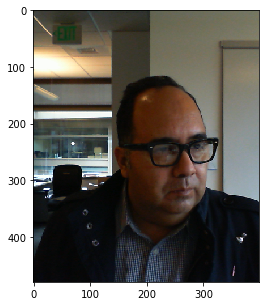

man: 98.73%


In [4]:
vid = cv2.VideoCapture(0)

plt.rcParams["figure.figsize"] = (10,5)

try:
    while(True):
        _, frame = vid.read()
        
        # GET THE VIDEO DIMENSIONS (DON'T ASSUME 640x480 :)
        (h, w, _) = frame.shape

        # WE WANT TO CLIP THE FULL VIDEO TO PORTRAIT SIZE BEFORE GIVING IT TO OUR MODEL
        new_width = int(h*.833333)
        startX = int((w-new_width)/2)
        imgClipped = frame[:, startX:startX+new_width]

        # CONVERT TO GRAY SCALE FOR FACE DETECTION
        gray = cv2.cvtColor(imgClipped, cv2.COLOR_BGR2GRAY)
        faces = faceCascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4, minSize=(100,100) )

        # BLACK OUT EVERYTHING THAT ISN'T IN THE FACE RECTANGLE
        for ( x, y, fw, fh) in faces:
            cv2.rectangle(imgClipped, (0,0), (w,y), (0,0,0), -1)
            cv2.rectangle(imgClipped, (0,0), (x, h), (0,0,0), -1)
            cv2.rectangle(imgClipped, (0, y+fh), (w,h), (0,0,0), -1)
            cv2.rectangle(imgClipped, (x+fw, 0), (w, h), (0,0,0), -1)

        
        tester = cv2.resize(imgClipped, (100,120))
        tester = tester.astype("float") / 255.0
        tester = img_to_array(tester)
        tester = np.expand_dims(tester, axis=0)
        conf = model.predict(tester)[0]
        
        imgClipped = cv2.cvtColor(imgClipped, cv2.COLOR_BGR2RGB)
        idx = np.argmax(conf)
        label = classes[idx]
        label = "{}: {:.2f}%".format(label, conf[idx] * 100)
        imshow(imgClipped)
        show()
        print(label)
        clear_output(wait=True)
except KeyboardInterrupt:
    vid.release()
